In [2]:
install.packages('rnn')

also installing the dependencies 'fs', 'rappdirs', 'sass', 'jquerylib', 'httpuv', 'mime', 'xtable', 'digest', 'htmltools', 'sourcetools', 'later', 'promises', 'fastmap', 'commonmark', 'bslib', 'cachem', 'sigmoid', 'shiny'




  There are binary versions available but the source versions are later:
       binary  source needs_compilation
bslib   0.2.4 0.2.5.1             FALSE
cachem  1.0.4   1.0.5              TRUE

  Binaries will be installed
package 'fs' successfully unpacked and MD5 sums checked
package 'rappdirs' successfully unpacked and MD5 sums checked
package 'sass' successfully unpacked and MD5 sums checked
package 'jquerylib' successfully unpacked and MD5 sums checked
package 'httpuv' successfully unpacked and MD5 sums checked
package 'mime' successfully unpacked and MD5 sums checked
package 'xtable' successfully unpacked and MD5 sums checked
package 'digest' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'digest'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\ProgramData\Anaconda3\Lib\R\library\00LOCK\digest\libs\x64\digest.dll to C:\ProgramData\Anaconda3\Lib\R\library\digest\libs\x64\digest.dll: Permission denied"Warning message:
"restored 'digest'"

package 'htmltools' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'htmltools'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\ProgramData\Anaconda3\Lib\R\library\00LOCK\htmltools\libs\x64\htmltools.dll to C:\ProgramData\Anaconda3\Lib\R\library\htmltools\libs\x64\htmltools.dll: Permission denied"Warning message:
"restored 'htmltools'"

package 'sourcetools' successfully unpacked and MD5 sums checked
package 'later' successfully unpacked and MD5 sums checked
package 'promises' successfully unpacked and MD5 sums checked
package 'fastmap' successfully unpacked and MD5 sums checked
package 'commonmark' successfully unpacked and MD5 sums checked
package 'cachem' successfully unpacked and MD5 sums checked
package 'sigmoid' successfully unpacked and MD5 sums checked
package 'shiny' successfully unpacked and MD5 sums checked
package 'rnn' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Shrestha\AppData\Local\Temp\Rtmp4IkZaz\downloaded_packages


installing the source package 'bslib'

Warning message in install.packages("rnn"):
"installation of package 'bslib' had non-zero exit status"

In [25]:
rnn

ERROR: Error in eval(expr, envir, enclos): object 'rnn' not found


In [24]:
trainr <- function(Y, X, model = NULL,learningrate, learningrate_decay = 1, momentum = 0, hidden_dim = c(10),network_type = "rnn",
                   numepochs = 1, sigmoid = c('logistic', 'Gompertz', 'tanh'), use_bias = F, batch_size = 1,
                   seq_to_seq_unsync=F,update_rule = "sgd",
                   epoch_function = c(epoch_print,epoch_annealing),
                   loss_function = loss_L1,...) {
  
  #  find sigmoid
  sigmoid <- match.arg(sigmoid)
  
  # coerce to array if matrix
  if(length(dim(X)) == 2){
    X <- array(X,dim=c(dim(X),1))
  }
  if(length(dim(Y)) == 2){
    Y <- array(Y,dim=c(dim(Y),1))
  }
  
  if(seq_to_seq_unsync){
    time_dim_input = dim(X)[2]
    store = array(0, dim = c(dim(X)[1],dim(X)[2]+dim(Y)[2]-1,dim(X)[3]))
    store[,1:dim(X)[2],] = X
    X = store
    store = array(0, dim = c(dim(X)[1],time_dim_input+dim(Y)[2]-1,dim(Y)[3]))
    store[,time_dim_input:dim(store)[2],] = Y
    Y = store
  }
  
  # check the consistency
  if(dim(X)[2] != dim(Y)[2] && !seq_to_seq_unsync){
    stop("The time dimension of X is different from the time dimension of Y. seq_to_seq_unsync is set to FALSE")
  }
  if(dim(X)[1] != dim(Y)[1]){
    stop("The sample dimension of X is different from the sample dimension of Y.")
  }
  
  
  # reverse the time dim if start from end
  # if(start_from_end){
  #   X <- X[,dim(X)[2]:1,,drop = F]
  #   Y <- Y[,dim(X)[2]:1,,drop = F]
  # }
  
  if(is.null(model)){
    # initialize the model list
    model                         = list(...) # we start by the ... argument before appending everybody else
    model$input_dim               = dim(X)[3]
    model$hidden_dim              = hidden_dim
    model$output_dim              = dim(Y)[3]
    model$synapse_dim             = c(model$input_dim,model$hidden_dim,model$output_dim)
    model$time_dim                = dim(X)[2] ## changed from binary_dim to get rid of the binary user case legacy
    model$sigmoid                 = sigmoid
    model$network_type            = network_type
    model$numepochs               = numepochs
    model$batch_size              = batch_size
    model$learningrate            = learningrate
    model$learningrate_decay      = learningrate_decay ## this one should be in the ... arg and be here initially but he was supply before
    model$momentum                = momentum
    model$update_rule             = update_rule
    model$use_bias                = use_bias
    model$seq_to_seq_unsync       = seq_to_seq_unsync
    model$epoch_function          = epoch_function
    model$loss_function           = loss_function
    model$last_layer_error        = Y*0
    model$last_layer_delta        = Y*0
    
    if("epoch_model_function" %in% names(model)){
      stop("epoch_model_function is not used anymore, use epoch_function and return the model inside.")
    }
    
    if(seq_to_seq_unsync){ ## this will work for the training, we need something to make in work for the predictr
      model$time_dim_input = time_dim_input
    }
    
    if(model$update_rule == "adagrad"){
      message("adagrad update, loss function not used and momentum set to 0")
      model$momentum = 0
    }
    
    model <- init_r(model)
    
    # Storing errors, dim 1: samples, dim 2 is epochs, we could store also the time and variable dimension
    model$error <- array(0,dim = c(dim(Y)[1],model$numepochs))
  }else{
    message("retraining, all options except X, Y and the model itself are ignored, error are reseted")
    if(model$input_dim != dim(X)[3]){
      stop("input dim changed")
    }
    if(model$time_dim != dim(X)[2]){
      stop("time dim changed")
    }
    if(model$output_dim != dim(Y)[3]){
      stop("output dim changed")
    }
    if(seq_to_seq_unsync && model$time_dim_input != time_dim_input){ ## this will work for the training, we need something to make in work for the predictr
      stop("time input dim changed")
    }
    
    # Storing errors, dim 1: samples, dim 2 is epochs, we could store also the time and variable dimension
    model$error <- array(0,dim = c(dim(Y)[1],model$numepochs))
  }
  
  
  # training logic
  for(epoch in seq(model$numepochs)){
    model$current_epoch = epoch
    index = sample(seq(round(dim(Y)[1]/model$batch_size)),dim(Y)[1],replace = T)
    lj = list()
    for(i in seq(round(dim(Y)[1]/model$batch_size))){lj[[i]] = seq(dim(Y)[1])[index == i]}
    lj[unlist(lapply(lj,length)) <1] = NULL
    
    for (j in lj) {
      # generate input and output for the sample loop
      a = X[j,,,drop=F]
      c = Y[j,,,drop=F]
      
      # feed forward
      store = predictr(model,a,hidden = T,real_output = F)
      if(model$network_type == "rnn"){
        for(i in seq(length(model$synapse_dim) - 1)){
          model$store[[i]][j,,] = store[[i]]
        }
      }else if(model$network_type == "lstm" | model$network_type == "gru" ){
        for(i in seq(length(model$hidden_dim))){
          model$store[[i]][j,,,] = store[[i]]
        }
        model$store[[length(model$hidden_dim)+1]][j,,] = store[[length(model$hidden_dim)+1]] # output
      }
      
      
      # apply back propagation
      model = backprop_r(model,a,c,j)
      
      # apply the loss function, default is to apply L1 learning rate, vocabulary to verify.
      if(model$update_rule == "sgd"){
        model = model$loss_function(model)
      }
      
      # Applying the update
      model = update_r(model)
      
    } # end sample loop
    
    # epoch_function
    for(i in model$epoch_function){
      model <- i(model)
      if(!is.list(model)){stop("one epoch function didn't return the model.")}
    }
    
  } # end epoch loop
  
  # update best guess if error is minimal, will make more sens to store the weight...
  if(colMeans(model$error)[epoch] <= min(colMeans(model$error)[1:epoch])){
    model$store_best <- model$store
  }
  
  # clean model object, get rid of the update mainly, potentially other cleaning if not necessary in predictr
  # model = clean_r(model)
  
  attr(model, 'error') <- colMeans(model$error)
  
  # return output
  return(model)
  
}

In [22]:
install.packages('trainr')

Warning message:
"package 'trainr' is not available (for R version 3.6.1)"Warning message:
"Perhaps you meant 'trainR' ?"

In [23]:
predictr

ERROR: Error in eval(expr, envir, enclos): object 'predictr' not found


In [3]:
#Load the necessary packages
require(rnn)


Loading required package: rnn
Warning message:
"package 'rnn' was built under R version 3.6.3"Error: package or namespace load failed for 'rnn' in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace 'htmltools' 0.3.6 is already loaded, but >= 0.5.0.9001 is required


In [7]:
#Function to be used later. Creating Training and Test Data Set
dataset <- function(data){
x <- y <- c()
for (i in 1:(nrow(data)-2))
{
    x <- append(x, data[i, 2])
    y <- append(y, data[i+1, 2])
}
output <- cbind(x,y)
return(output[1:nrow(output)-1,])
}


In [8]:
#Monthly Milk Production: Pounds Per Cow
data <- read.table("milk.csv", header = TRUE, sep = ",")


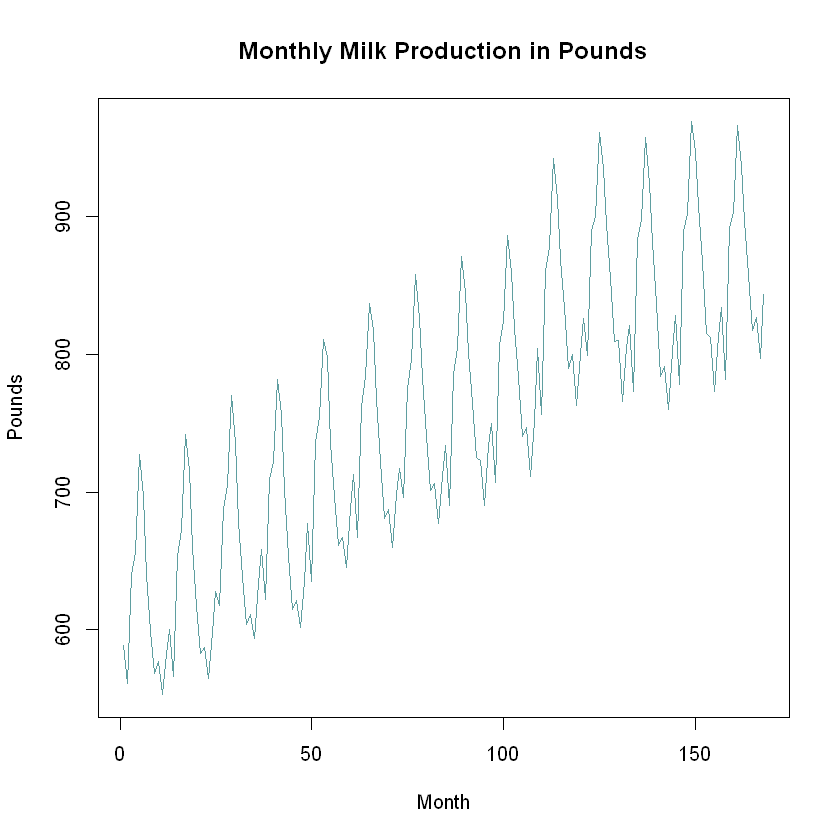

In [9]:
#Plotting Sequence
plot(data[,2], main = "Monthly Milk Production in Pounds", xlab = "Month", ylab = "Pounds", lwd = 1.5, col = "cadetblue", type = "l")


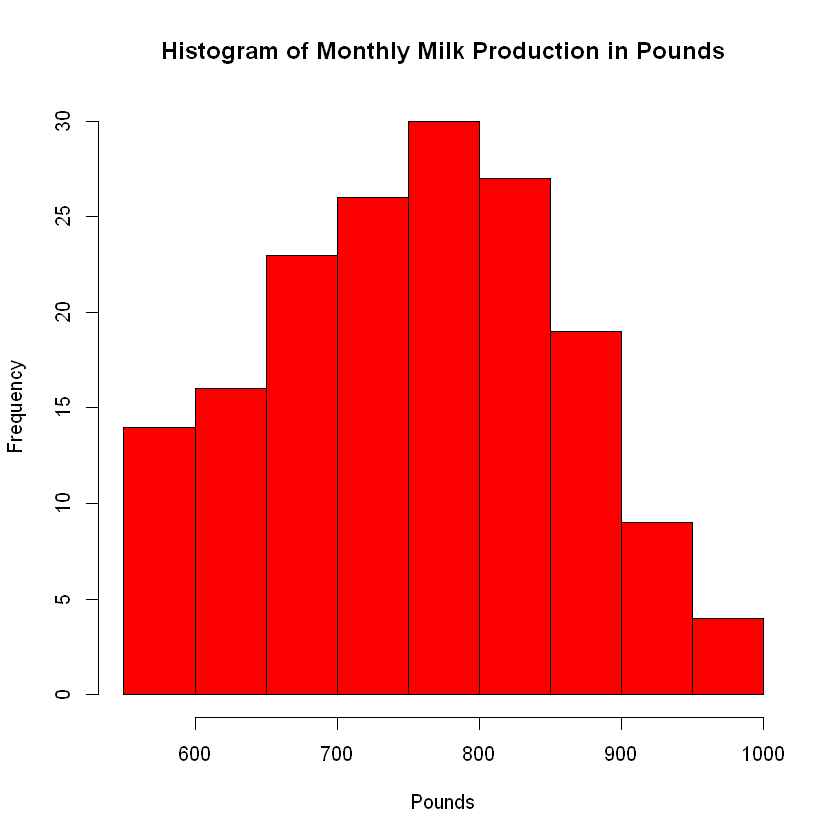

In [10]:
#Ploting Histogram
hist(data[,2], main = "Histogram of Monthly Milk Production in Pounds", xlab = "Pounds", col = "red")


In [11]:
#Creating Test and Training Sets
newData <- dataset(data = data)


In [12]:
#Creating Test and Train Data
rows <- sample(1:120, 120)
trainingData <- scale(newData[rows, ])
testData <- scale(newData[-rows, ])


In [13]:
#Max-Min Scaling
x <- trainingData[,1]
y <- trainingData[,2]
train_x <- (x - min(x))/(max(x)-min(x))
train_y <- (y - min(y))/(max(y)-min(y))


In [16]:
#RNN Model
RNN <- trainr(Y = as.matrix(train_x),X = as.matrix(train_y),
learningrate = 0.04, momentum = 0.1, network_type = "rnn", 
numepochs = 700, hidden_dim = 3)
y_h <- predictr(RNN, as.matrix(train_x))


ERROR: Error in trainr(Y = as.matrix(train_x), X = as.matrix(train_y), learningrate = 0.04, : could not find function "trainr"


In [27]:
install.packages('mltools')

also installing the dependency 'data.table'



package 'data.table' successfully unpacked and MD5 sums checked
package 'mltools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Shrestha\AppData\Local\Temp\Rtmp4IkZaz\downloaded_packages


In [26]:
library(mltools)

ERROR: Error in library(mltools): there is no package called 'mltools'
